In [1]:
import torch
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np
import zipfile
import io
import pandas as pd
import math
from IPython.display import display
from collections import defaultdict

zipped_data_path = "../data/clean_data/class-competition-cleaned.zip"

dataframes = defaultdict(pd.DataFrame)
with zipfile.ZipFile(zipped_data_path, "r") as zipf:
    for filename in zipf.namelist():
        if filename.endswith(".csv"):
            with zipf.open(filename) as f:
                dataframes.update({ filename : pd.read_csv(io.TextIOWrapper(f)) })

                # Lets take a look at the files
                print(f"FILE: {filename}")
                # If you want to see file info uncomment this:
                # display(dataframes[filename].info())
                # display(dataframes[filename].head())

FILE: train_call_type_A.csv
FILE: train_call_type_B.csv
FILE: train_call_type_C.csv
FILE: test_public.csv


In [2]:
train_data = dataframes["train_call_type_B.csv"]
test_data  = dataframes["test_public.csv"]
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [3]:
# Split the START_LOCATION into two new columns for latitude and longitude for train set
for i, j in train_data['START_LOCATION'].items():
    split = j.split(',')
    train_data.at[i, 'START_LAT'] = split[0]
    train_data.at[i, 'START_LONG'] = split[1]
train_data.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,POLYLINE,TRAVEL_TIME,START_LOCATION,MON_sin,MON_cos,...,DAY_cos,HR_sin,HR_cos,MIN_sin,MIN_cos,WK_sin,WK_cos,YR_2013,START_LAT,START_LONG
0,1372637303620000596,B,NaN,7.0,20000596,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,"41.1599801853,-8.64198392478",1.224647e-16,-1.0,...,0.97953,-0.965926,-0.258819,0.743145,0.669131,-0.781831,0.62349,True,41.1599801853,-8.64198392478
1,1372638481620000403,B,NaN,28.0,20000403,"[[-8.584263,41.163156],[-8.584695,41.163003],[...",960,"41.1632224305,-8.58404677278",1.224647e-16,-1.0,...,0.97953,-0.965926,-0.258819,0.207912,-0.978148,-0.781831,0.62349,True,41.1632224305,-8.58404677278
2,1372639960620000309,B,NaN,38.0,20000309,"[[-8.60418,41.160969],[-8.603874,41.1615],[-8....",285,"41.1607148883,-8.60424608207",1.224647e-16,-1.0,...,0.97953,-0.965926,-0.258819,-0.743145,0.669131,-0.781831,0.62349,True,41.1607148883,-8.60424608207
3,1372639635620000178,B,NaN,52.0,20000178,"[[-8.613243,41.154444],[-8.612811,41.153733],[...",255,"41.1549650972,-8.61321698848",1.224647e-16,-1.0,...,0.97953,-0.965926,-0.258819,-0.978148,0.207912,-0.781831,0.62349,True,41.1549650972,-8.61321698848
4,1372639973620000686,B,NaN,23.0,20000686,"[[-8.61255,41.146128],[-8.612199,41.146074],[-...",285,"41.1460158298,-8.61257471887",1.224647e-16,-1.0,...,0.97953,-0.965926,-0.258819,-0.743145,0.669131,-0.781831,0.62349,True,41.1460158298,-8.61257471887


In [4]:
# Use only data points with CALL_TYPE B
test_data = test_data[test_data['CALL_TYPE'] == 'B']
# Split the START_LOCATION into two new columns for latitude and longitude for test set
for i, j in test_data['START_LOCATION'].items():
    split = j.split(',')
    test_data.at[i, 'START_LAT'] = split[0]
    test_data.at[i, 'START_LONG'] = split[1]
test_data.head()

C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_19232\2665617917.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.at[i, 'START_LAT'] = split[0]
C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_19232\2665617917.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.at[i, 'START_LONG'] = split[1]


,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,START_LOCATION,MON_sin,MON_cos,DAY_sin,DAY_cos,HR_sin,HR_cos,MIN_sin,MIN_cos,WK_sin,WK_cos,YR_2013,START_LAT,START_LONG
0,T1,B,NaN,15.0,20000542,"41.1486275073,-8.58587660305",-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,-0.309017,0.951057,0.433884,-0.900969,False,41.1486275073,-8.58587660305
1,T2,B,NaN,57.0,20000108,"41.1457188058,-8.61070701502",-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,-0.866025,0.500000,0.433884,-0.900969,False,41.1457188058,-8.61070701502
2,T3,B,NaN,15.0,20000370,"41.1486275073,-8.58587660305",-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,-0.913545,0.406737,0.433884,-0.900969,False,41.1486275073,-8.58587660305
3,T4,B,NaN,53.0,20000492,"41.1412081961,-8.61401226127",-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,-0.207912,0.978148,0.433884,-0.900969,False,41.1412081961,-8.61401226127
4,T5,B,NaN,18.0,20000621,"41.1483209068,-8.61960347647",-0.866025,-0.5,0.299363,-0.954139,0.5,-0.866025,-0.104528,0.994522,0.433884,-0.900969,False,41.1483209068,-8.61960347647


In [5]:
from sklearn.preprocessing import StandardScaler
mean_encoding = train_data.groupby('TAXI_ID')['TRAVEL_TIME'].mean().reset_index()

# Create a dictionary mapping 'TAXI_ID' to mean 'TRAVEL_TIME' value
mean_encoding_dict = dict(zip(mean_encoding['TAXI_ID'], mean_encoding['TRAVEL_TIME']))

# Replace the 'TAXI_ID' values with mean target encoding values
train_data.loc[:, 'TAXI_ID_MEAN_ENC'] = train_data['TAXI_ID'].map(mean_encoding_dict)
test_data.loc[:, 'TAXI_ID_MEAN_ENC'] = test_data['TAXI_ID'].map(mean_encoding_dict)

mean_enc_train = pd.DataFrame(train_data['TAXI_ID_MEAN_ENC'])
mean_enc_test = pd.DataFrame(test_data['TAXI_ID_MEAN_ENC'])

# Initialize StandardScaler and fit it on the mean encoding column
scaler = StandardScaler()
scaler.fit(mean_enc_train)

# Transform the mean encoding column using the fitted scaler
normalized_enc_train = scaler.transform(mean_enc_train)
normalized_enc_test = scaler.transform(mean_enc_test)

# Replace the original mean encoding column with the normalized values
train_data.loc[:, 'TAXI_ID_MEAN_ENC_NORMALIZED'] = normalized_enc_train
test_data.loc[:, 'TAXI_ID_MEAN_ENC_NORMALIZED'] = normalized_enc_test

latitude_train = pd.DataFrame(train_data['START_LAT'].astype(float))
longitude_train = pd.DataFrame(train_data['START_LONG'].astype(float))
latitude_test = pd.DataFrame(test_data['START_LAT'].astype(float))
longitude_test = pd.DataFrame(test_data['START_LONG'].astype(float))

scaler = StandardScaler()
scaler.fit(latitude_train)

normalized_latitude_train = scaler.transform(latitude_train)
normalized_latitude_test = scaler.transform(latitude_test)

scaler = StandardScaler()
scaler.fit(longitude_train)

normalized_longitude_train = scaler.transform(longitude_train)
normalized_longitude_test = scaler.transform(longitude_test)

train_data.loc[:, 'START_LAT_NORMALIZED'] = normalized_latitude_train
train_data.loc[:, 'START_LONG_NORMALIZED'] = normalized_longitude_train
test_data.loc[:, 'START_LAT_NORMALIZED'] = normalized_latitude_test
test_data.loc[:, 'START_LONG_NORMALIZED'] = normalized_longitude_test

train_data.info()

C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_19232\2202226963.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'TAXI_ID_MEAN_ENC'] = test_data['TAXI_ID'].map(mean_encoding_dict)
C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_19232\2202226963.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'TAXI_ID_MEAN_ENC_NORMALIZED'] = normalized_enc_test


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 721030 entries, 0 to 721029
Data columns (total 25 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TRIP_ID                      721030 non-null  int64  
 1   CALL_TYPE                    721030 non-null  object 
 2   ORIGIN_CALL                  0 non-null       float64
 3   ORIGIN_STAND                 721030 non-null  float64
 4   TAXI_ID                      721030 non-null  int64  
 5   POLYLINE                     721030 non-null  object 
 6   TRAVEL_TIME                  721030 non-null  int64  
 7   START_LOCATION               721030 non-null  object 
 8   MON_sin                      721030 non-null  float64
 9   MON_cos                      721030 non-null  float64
 10  DAY_sin                      721030 non-null  float64
 11  DAY_cos                      721030 non-null  float64
 12  HR_sin                       721030 non-null  float64
 13 

C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_19232\2202226963.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'START_LAT_NORMALIZED'] = normalized_latitude_test
C:\Users\Tyler Holston\AppData\Local\Temp\ipykernel_19232\2202226963.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[:, 'START_LONG_NORMALIZED'] = normalized_longitude_test


In [6]:
from sklearn.model_selection import train_test_split

# We could totally change this. Utilization of these just probably requires further preprocessing.
ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION = ['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'POLYLINE', 'START_LOCATION', 'TAXI_ID_MEAN_ENC', 'TAXI_ID', 'START_LAT', 'START_LONG']

train_data_sample = train_data.sample(frac=0.8, random_state=420) # frac is used to control percentage of train data used
X = train_data_sample.drop("TRAVEL_TIME", axis=1)
X = X.loc[:, ~X.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]
y = train_data_sample["TRAVEL_TIME"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=420)

test_features = test_data.loc[:, ~test_data.columns.isin(ALL_FEATURES_NOT_SUITED_FOR_ESTIMATION)]

In [7]:
from torch.utils.data import DataLoader, Dataset
from mlp_utils import TaxiDataset
    
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_test_public = test_features.astype(float) # This is what we can predict on

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.tolist(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.tolist(), dtype=torch.float32)
X_test_public_tensor = torch.tensor(X_test_public.values, dtype=torch.float32)

train_dataset = TaxiDataset(X_train_tensor, y_train_tensor)
test_dataset = TaxiDataset(X_test_tensor, y_test_tensor)
test_public_dataset = TaxiDataset(X_test_public_tensor)

batch_size = 32

dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
dataloader_pred = DataLoader(test_public_dataset, batch_size=batch_size)

In [8]:
import torch.nn.functional as F

def init_weights(m):
  if isinstance(m, nn.Linear):
    nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

class MLP(nn.Module):
  '''
    Multilayer Perceptron for regression.
  '''
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(15, 256)
    self.fc2 = nn.Linear(256, 256)
    self.fc3 = nn.Linear(256, 256)
    self.fc4 = nn.Linear(256, 128)
    self.fc5 = nn.Linear(128, 64)
    self.fc6 = nn.Linear(64, 1)
    self.apply(init_weights)
    self.apply(init_weights)

  def forward(self, x):
    '''
      Forward pass
    '''
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.relu(self.fc5(x))
    x = self.fc6(x)
    return x

In [9]:
from mlp_utils import num_parameters

mlp = MLP()
if torch.cuda.is_available():
    mlp.cuda()
 
num_parameters(mlp)

176897

In [13]:
from mlp_utils import pipeline
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(mlp.parameters(), lr=0.005, weight_decay=1e-2)

train_losses, test_loss, predictions = pipeline(mlp, optimizer, dataloader_train=dataloader_train, 
                                                dataloader_test=dataloader_test, dataloader_pred=dataloader_pred,
                        			device=device, criterion=criterion, epochs=10)

100%|██████████| 10/10 [06:08<00:00, 36.86s/it]


Training process has finished.


In [16]:
print(f"Final Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_loss}")

Final Train Loss: 339.2547100813707
Test Loss: 339.35056568940854


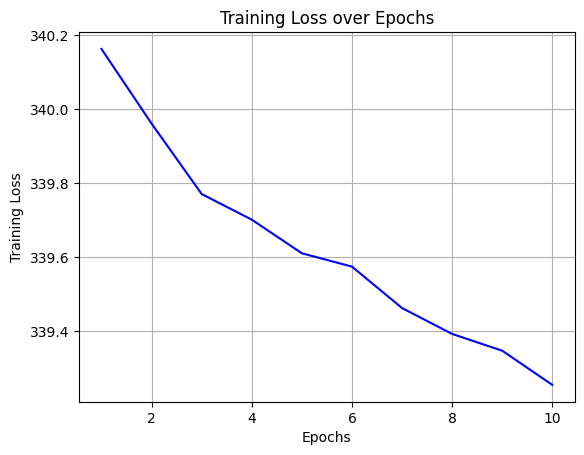

[340.16222952950324, 339.960629664207, 339.7702986585858, 339.7010497134777, 339.6102791192188, 339.57421762292944, 339.46223659147074, 339.3924105445339, 339.34704365226776, 339.2547100813707]


In [17]:
import matplotlib.pyplot as plt

# Create x-axis values (epochs)
epochs = range(1, len(train_losses) + 1)

# Plot the training loss
plt.plot(epochs, train_losses, 'b-')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Training Loss over Epochs')
plt.grid(True)
plt.show()

print(train_losses)

In [18]:
from mlp_utils import test_prediction_to_csv

test_prediction_to_csv(predictions, "predicting_six_layer_mlp_call_type_b_min.csv", test_data)